# Decrypting Vigenere Ciphers

_Author: Matthieu Lequesne._

_Version: 20230914_

_Based on earlier X tutorials by François Morain and Benjamin Smith._

## Introduction

### Ceasar cipher

The **Caesar cipher** is a substitution cipher in which each letter in the plaintext is replaced by a letter some fixed number of positions down the alphabet.
Eg. if we shift each letter by 3 positions in the alphabet:
- plaintext `a` maps to ciphertext `D`,
- plaintext `b` maps to ciphertext `E`,
- plaintext `c` maps to ciphertext `F`,
- ...
- plaintext `z` maps to ciphertext `C`.

Hence, `crypto` is maped to `FUBSWR`.

_(Note that we always use lower-case letters for plaintext symbols and UPPER-CASE LETTERS for ciphertext symbols.)_

The Caesar cipher uses a very simple key, corresponding to the value of the shift (26 possibilities) and is hence extremely easy to break using bruteforce. 

However, the Caesar cipher, is notoriously insecure. The Caesar cipher is a particular case of monoalphabetic substitution cipher. These ciphers preserve a lot of the statistical structure of the plaintext's language.  In particular, the most frequent ciphertext symbols generally represent the most frequent letters of the plaintext (especially when the plaintext is long, so its statistics conform better to general texts in the target language).

Figuring out which ciphertext symbols represent the **most common letters** of the alphabet is relatively easy.  For example, "e" is the most common letter in French and in English, so the most common symbol in the ciphertext probably represents "e"! With high probability, the most common letter in the ciphertext corresponds to the encryption of "e" and this information is enough to deduce the value of the shift. Eg., if the most common letter in the ciphertext is "J" then the value of the shift is almost certainly 5.

### Vigenere cipher

The **Vigenere Cipher** consists in writing the plaintext in a grid of fixed length and applying a Cesar cipher to each column. Each column is shifted by a different number of positions in the alphabet. The length of the grid and the value of the shift for each column constitute the key.

Example: to encrypt `secretmessage` using the key `[3, 1, 6, 18]` (key of length 4) we start by writing the plaintext in a grid of width 4:
```
s e c r
e t m e
s s a g
e
```

- 1st column: apply a Ceasar cipher of shift `3` (`s`->`V`, etc.),
- 2nd column: apply a Ceasar cipher of shift `1` (`e`->`F`, etc.),
- 3rd column: apply a Ceasar cipher of shift `6` (`c`->`I`, etc.),
- 4th column: apply a Ceasar cipher of shift `18` (`r`->`J`, etc.),
```
V F I J
H U S W
V T G Y 
H
```
And the ciphertext is `VFIJHUSWVTGYH`.

The difficulty to decrypt a Vigenere ciphertext is that you do not know the length of the key (ie. the number of columns). Therefore there is two steps in the decryption process:
1. finding the length of the key;
2. finding the value of the shift applied to each column.

## Getting started

### Setting the target language
Our main tool today is **frequency analysis**: we will exploit the statistical properties of the message's language. Different languages have different expected symbol frequencies, so we should fix a target language once and for all.  

The `language` variable defines the target language.
- By default, we will set `language` to `'fr'` to attack messages written in French.
- Use `'en'` for messages in English, `'de'` for German

In [1]:
language = 'fr' # French by default; use 'en' for messages in English, 'de' for German

### Selecting a target  ciphertext

Now we need to choose a ciphertext to attack.  For this tutorial, we have
- 8 ciphertexts corresponding to French plaintexts: set `target_number` to an integer between 1 and 8 (inclusive)
- 2 ciphertexts corresponding to English plaintexts: set `target_number` to an integer between 1 and 2 (inclusive)
- 4 ciphertexts corresponding to German plaintexts: set `target_number` to an integer between 1 and 4 (inclusive)

If you **change your challenge number**, then you need to re-run this cell _and all of the following cells_ (to update the frequency tables and re-start the solver).  The easiest way to do this is to use the "fast-forward" button in Jupyter.

In [2]:
target_number = 1  # By default

# DO NOT MODIFY THE FOLLOWING LINES

# Check parameters are sane before things get out of hand
assert (language == 'fr' and 1 <= target_number <= 8) \
        or (language == 'en' and 1 <= target_number <= 3) \
        or (language == 'de' and 1 <= target_number <= 4) 

# Define ciphertext filename
ciphertext_filename = f'Challenges/vigenere/{language}/{target_number:0>2}.txt'  # DO NOT MODIFY THIS LINE

In [ ]:
# For the assignment, to import the ciphertext from a specific file
# uncomment the next line and modify the path to the location of the ciphertext on your computer 
# ciphertext_file = "path/to/the/ciphertext.txt"

## A first look at the ciphertext

Let's open the ciphertext file, and have a quick look at the challenge ahead of us:

In [3]:
# DO NOT MODIFY THIS CELL
ciphertext_file = open(ciphertext_filename, 'r')
ciphertext = ciphertext_file.read()
print(ciphertext)

SMBLYGMTRKBMPNWUYDIUTIANANFZRKUTNPSKNOMKBWFYSWNZYJ
PMYUUCVLRWPMFLWECAMWZBFXWUNTRWEINNLTUAIJXMFCFUYNXW
EQYGSCJAVAEIYYKQVDIJHMEMGWMWIKBQRLJGMOEFETRMEQODWW
EWHXSPMWIKFWHLTKYCIKXMFCFUYNXWELRMCGLRYWXMAMGPNLTL
QZRMANMYIHQCIYFVPZPWDMALSKMZRVQTRRLTYXINUWYYFEYOYN
QVGKMKUQMFUXNLSVLZTZUMEFWWLDEAXMF



**Observe:**
1. We always use UPPER-CASE LETTERS for the ciphertext alphabet
2. We use lower-case letters for the plaintext alphabet
3. **All spaces and punctuation have been removed** from the plaintext before encryption. _(Encrypted spaces would be easy to identify, and then this would immediately reveal the lengths and structures of individual words...  Which is too easy!)_
4. Here, we wrap lines of ciphertext at 50 characters, to try to keep things readable - but this means that words might be broken across lines

### Loading the toolbox

Now we're ready to load the `substitution` module, which contains some useful tools for breaking substitution ciphers, and create a `Solver` object to attack our specific ciphertext.

In [4]:
# DO NOT MODIFY THIS CELL
import vigenere  # Today's toolbox
solver = vigenere.Solver(ciphertext_filename, language)

## Finding the key length

The first step of the cryptanalysis of a text encrypted using a Vigenere cipher is to find the length of the encryption key. For this, we have two tools.

### Kasiski: finding repeated patterns

If the plaintext contains two equal sequence of letters, whose distance in the text is a multiple of the key length, they will be encrypted the same way. Reciprocally, a repeated pattern in the ciphertext probably corresponds to a repeated pattern in the plaintext. Hence, the distance between repeated pattern provides an information on the length of the key.

The `solver` object can compute for us the longest repeated patterns and the distance between the two occurence of the pattern.

In [5]:
solver.kasiski()  # DO NOT MODIFY

Kasiski: 20 longest repeated patterns


,pattern,1st occurence,2nd occurence,distance,divisors
0,XMFCFUYNXWE,90,170,80,"[2, 4, 5, 8, 10, 16, 20, 40, 80]"
1,XMFCFUYNXW,90,170,80,"[2, 4, 5, 8, 10, 16, 20, 40, 80]"
2,MFCFUYNXWE,91,171,80,"[2, 4, 5, 8, 10, 16, 20, 40, 80]"
3,XMFCFUYNX,90,170,80,"[2, 4, 5, 8, 10, 16, 20, 40, 80]"
4,MFCFUYNXW,91,171,80,"[2, 4, 5, 8, 10, 16, 20, 40, 80]"
5,FCFUYNXWE,92,172,80,"[2, 4, 5, 8, 10, 16, 20, 40, 80]"
6,XMFCFUYN,90,170,80,"[2, 4, 5, 8, 10, 16, 20, 40, 80]"
7,MFCFUYNX,91,171,80,"[2, 4, 5, 8, 10, 16, 20, 40, 80]"
8,FCFUYNXW,92,172,80,"[2, 4, 5, 8, 10, 16, 20, 40, 80]"
9,CFUYNXWE,93,173,80,"[2, 4, 5, 8, 10, 16, 20, 40, 80]"


### Friedman: computing the auto-correlation index

The correlation index between two messages (of equal length) is the number of positions where the symbols in both messages are the same, divided by the length of the messages. Eg. the correlation index of `CRYPTOGRAPHIE` and `POLYTECHNIQUE` is $2/13 \simeq0.15$.

For an integer $k$, we compute the correlation index between the ciphertext $(c_0, c_1, \ldots, c_{N-k})$ and the ciphertext starting at the k-th position $(c_k, c_{k+1}, \ldots, c_N)$.

If $k$ is the length of the key (or a multiple of it), this value should be higher (if the message is in French, this value should be around 0.078, compared to 0.038 for other $k$).

Hence we can compute this index for all possible values of $k$. The values of $k$ that correspond to a high auto-correlation index are probably multiples of the key length.

The `solver` object can compute these values for us.

Friedman: value of auto-correlation index for 1 <= k < 50


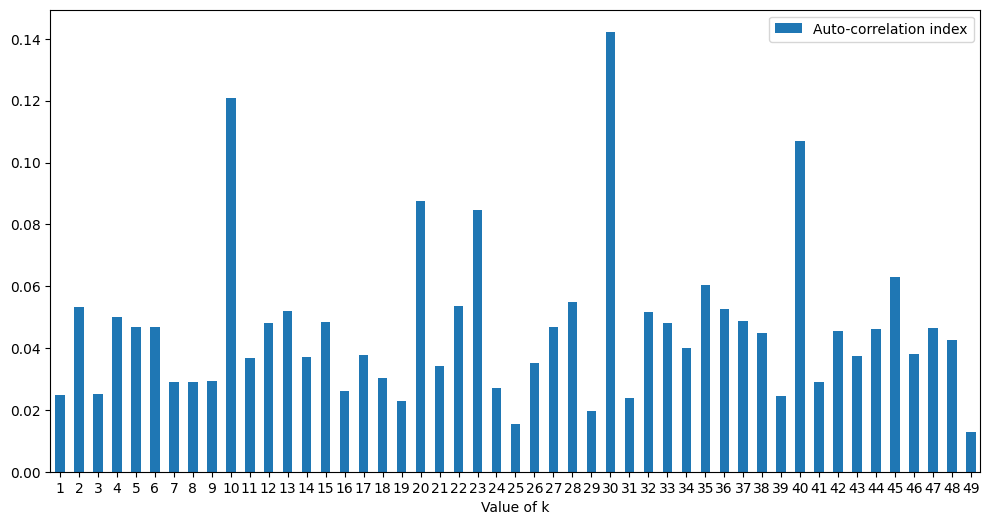

In [6]:
solver.friedman()  # DO NOT MODIFY

## Decrypting each column

Once the key length is fixed, this defines the columns of the ciphertext. Each column of the ciphertext corresponds to a column of the plaintext encrypted using a Ceasar cipher. For each column, we should find the value of the shift (26 choice). Several statistical methods can help

In [7]:
# IMPORTANT: before using the tools below, set the value of the key length
key_length = 10 # <=== MODIFY THIS VALUE
solver.set_key_length(key_length)

Key length set to 10.


In [8]:
# IMPORTANT: before using the tools below, set the value of the column that you want to decrypt
i_column = 1 # <=== MODIFY THIS VALUE

### Bruteforcing

For a given column, we can apply the 26 possible values of the shift and see what happens. The correct shift should yield letters that are more frequent in the language of the plaintext.

In [9]:
solver.bruteforce_column(i_column)

/home/laplace_demon/WorkPlace/courses/crypto/Lab1/vigenere.py:230: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df = df.style.applymap(apply_monospace_font)


,shift,text
0,0,mmitwmmbimqimqtwwmlmzcmtwvxm
1,1,nnjuxnncjnrjnruxxnmnadnuxwyn
2,2,ookvyoodkoskosvyyonobeovyxzo
3,3,pplwzppelptlptwzzpopcfpwzyap
4,4,qqmxaqqfmqumquxaaqpqdgqxazbq
5,5,rrnybrrgnrvnrvybbrqrehrybacr
6,6,ssozcsshoswoswzccsrsfiszcbds
7,7,ttpadttiptxptxaddtstgjtadcet
8,8,uuqbeuujquyquybeeutuhkubedfu
9,9,vvrcfvvkrvzrvzcffvuvilvcfegv


### Maximizing frequent letters

Instead of bruteforcing, we can automate the search for frequent letters. One simple method is to compute the 10 most frequent letters in the shifted column and see how many of these letters belong to the 10 most frequent letters in the alphabet of the ciphertext.

In [10]:
solver.maximize_frequent_letters(i_column)

Top 10 values of shift with highest intersection of frequent letters


/home/laplace_demon/WorkPlace/courses/crypto/Lab1/vigenere.py:252: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df = df.style.applymap(apply_monospace_font)


,shift,size of intersection,text
0,18,8,eealoeetaeiaeilooederuelonpe
1,3,5,pplwzppelptlptwzzpopcfpwzyap
2,12,5,yyufiyynuycuycfiiyxyloyfihjy
3,21,5,hhdorhhwdhldhlorrhghuxhorqsh
4,22,5,iiepsiixeimeimpssihivyipsrti
5,23,5,jjfqtjjyfjnfjnqttjijwzjqtsuj
6,24,5,kkgrukkzgkogkoruukjkxakrutvk
7,1,4,nnjuxnncjnrjnruxxnmnadnuxwyn
8,2,4,ookvyoodkoskosvyyonobeovyxzo
9,5,4,rrnybrrgnrvnrvybbrqrehrybacr


### Maximizing transition probabilities

Once a column is deciphered, it becomes easier to decipher the neighbour columns. Indeed, it is possible to work 
on the bigrams to see if they are probable or not. For instance, in English, a `T` is more frequently followed by a `H` than by a `Z`. Hence if the left column contains a `T`, the right column is more likely to have an `H` in this row. If the left column has been deciphered, we can compute for all possible shifts of the right column an index that reflects the likelyhood that the bigrams appear in the text. This is the transition probability. The higher the transition probability, the more likely we have found the correct shift.

## Interactive Solving with the "Shell"

Now we launch the substitution **shell**.  This cell contains an interactive loop that lets us iteratively try various partial decryptions and see the results. 

To launch the shell, run the following cell.  A guide to using the shell is included just below, followed by some cryptanalysis hints.  

_Depending on your Jupyter environment, you may be able to increase the cell height slightly to avoid too much annoying vertical scrolling..._

In [12]:
# DO NOT MODIFY THIS CELL
sh = vigenere.Shell(solver)
sh.cmdloop()

Welcome to the Vigenere cipher solver.  Type help or ? to list commands.

List of commands:
- 'best j' 	finds the best shift for column j
- 'help' 	prints the help
- 'key' 	shows the key
- 'length n' 	sets the key length to n
- 'quit' 	quits the loop
- 'unset j' 	unsets the column j
- 'set j s' 	sets the shift of column j to s
- 'show' 	shows the deciphered text

Start by setting the key length using the command 'length'.

Key length set to 10.
Key length set to 10.
Key length = 10
Key = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
-1 = key value not set
[shift, #intersection, trans_proba]
[[14, 6, 0], [19, 6, 0], [3, 5, 0], [10, 5, 0], [15, 5, 0]]
[shift, #intersection, trans_proba]
[[18, 8, 0], [3, 5, 0], [12, 5, 0], [21, 5, 0], [22, 5, 0]]
[shift, #intersection, trans_proba]
[[18, 8, 0], [3, 5, 0], [12, 5, 0], [21, 5, 0], [22, 5, 0]]
[shift, #intersection, trans_proba]
[[14, 6, 524], [19, 6, 255], [3, 5, 280], [10, 5, 364], [15, 5, 364]]
*** Unknown syntax: sgiw
g e o - g e s - - -
p e 

## Shell Commands

The main shell commands are
- `help`: Lists available commands.  For more help on a given command, run `help commandname`.
- `quit`: Quits the shell (re-run the cell to restart)
- `length n`: Sets the key length to `n`
- `show`: Display the current partial decryption.  The text is displayed in columns corresponding to the key length.
- `best j`: Displays the best shift values for column `j`, using the intersection of frequent letters and the transition probabilities if the shift value of the neighbour column is already set.
- `set j s`: Sets the shift of column `j` to `s`.
- `unset j`: Resets the shift of column `j` to an unknown value.
- `key`: Displays the current value of the key.

## Hints

### 1. Find the key length 

Use Kasiski's (finding repeated patterns) and Friedman's (computing the auto-correlation index) tools! The multiples of the key length will stand out with higher index values. Fix this value using `length`.

### 2. Use the intersection of frequent letters to find the shift of one column

Using `best` (or the graphical tool above), find one column where this indicator yields a good result (eg. 8 out of 10). It will not necessarily be the case for the first column, but keep trying. Fix this value using `set`.

### 3. Use transition probabilities to decrypt the neighbouring columns

Once you have fixed the shift of one column, the transition probabilities given by `best` will provide you with a very good indicator to find the shift of the neighbouring columns. Fix this value using `set`. Repeat this until you have decrypted all columns.

### 4. Look at the decrypted text

**Run `show` each time you `set` a symbol**, to see if the partial decryption confirms your suspicions. If you think you've made a mistake, you can always undo it with `unset`.

### 5. Be patient!

Cryptanalysis is hard.  Don't be put off by this! Keep trying, and **ask us for help** if you need more hints or encouragement! 